### **Synthetic Control**


### Background
Unlike the Difference-in-Differences (DiD) method, synthetic control is a frequently employed technique when dealing with datasets where there is a significant imbalance between the number of control units and treated units. DiD methods typically demand a high degree of comparability between the treated and control groups to establish the critical "parallel trend" assumption. However, this assumption becomes challenging to fulfill when the dataset contains only a limited number, or even just a single, treated unit, often due to issues related to data collection or funding constraints. In this situation, synthetic control aims to reweight the substantial information in control group to provide another perspective to learn the conterfactuals for treated unit(s).

To illustrate the basic idea of synthetic control, we suppose that there are $N$ units and $T$ time periods in total, and denote $Y_{it}$ as the outcome for unit $i$ in period $t$. Without the loss of generality, suppose the first $N_{\text{tr}}$ units are in the treated group, which will receive treatment starting from period $T_0+1$. The rest $N_{\text{co}} := N-N_{\text{tr}}$ units belong to the control group, which have no possibility to be exposed to treatment at any time.


### Algorithm 

There are two main steps in synthetic control methods: 

**Step 1:** Calculate the weights $\hat{\omega}_i^{\text{sdid}}$ that align pre-exposure trends in the outcome of control units for treated units；

\begin{equation}
    \hat{Y}_{it} = \hat{\omega}_{i0} + \sum_{j=N_{\text{co}}+1}^{N}\hat{\omega}_{ij} Y_{jt}, \qquad \forall i\in\{1,\dots, N_{\text{tr}}\}, \forall t\in \{1,\dots,T\},
\end{equation}
where 
\begin{equation}
\hat{\omega}_i = \arg\min_{\omega} \sum_{1\leq t\leq T_0} \bigg(Y_{it} - \omega_{i0} -\sum_{j=1}^{N_{\text{co}}} \omega_{ij} Y_{jt}\bigg)^2
\end{equation}


**Step 2:** Use the weights to estimate the post-exposure conterfactuals in causal effect estimation.




### Demo
In the following part, we use the [Abadie-Diamond-Hainmueller California smoking data](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746?casa_token=aNT_5z3JHO0AAAAA:vyxa3Kh7WQsLZ0w5CzcvyiV-YvIJHO8kJOgYkfM14zIipcgSLxEJXN2Fr0BCpJax3xihcqbCt9S1) to illustrate how we can calculate the treatment effect on the treated via synthetic control.

In this dataset, our goal aims to study the effects of Proposition 99, a large-scale tobacco
control program that California implemented in 1988. Typically, the annual tobacco consumption was evaluated from 1970 to 2000 for a total of $N=39$ states (including California). Therefore, this dataset contains $N = 39$ units with $N_{\text{co}} = 38$ states in the control group, and only one unit ($N_{\text{tr}} = 1$, corresponding to the California state) starting from the $19$th period.


In [90]:
# load the data
# california smoking data: https://github.com/susanathey/MCPanel/blob/master/tests/examples_from_paper/california/smok_outcome.csv
import numpy as np
import pandas as pd
import os
os.chdir('/Users/alinaxu/Documents/CDM/CausalDM')
smoke_X = pd.read_csv('./causaldm/data/smoke_covariates.csv', header = None)
smoke_A = pd.read_csv('./causaldm/data/smoke_treatment.csv', header = None)
smoke_R = pd.read_csv('./causaldm/data/smoke_outcome.csv', header = None)

smoke_R.index = list(np.linspace(1970,2000,31).astype(int).astype(str))
smoke_A.index = list(np.linspace(1970,2000,31).astype(int).astype(str))
smoke_R = smoke_R.rename(columns={0: "California"})
smoke_A = smoke_A.rename(columns={0: "California"})

smoke_R.head()

,California,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
1970,123.0,89.8,100.3,124.8,120.0,155.0,109.9,102.4,124.8,134.6,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
1971,121.0,95.4,104.1,125.5,117.6,161.1,115.7,108.5,125.6,139.3,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
1972,123.5,101.1,103.9,134.3,110.8,156.3,117.0,126.1,126.6,149.2,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
1973,124.4,102.9,108.0,137.9,109.3,154.7,119.8,121.8,124.4,156.0,...,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
1974,126.7,108.2,109.7,132.8,112.4,151.3,123.7,125.6,131.9,159.6,...,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8


Details about the dataset:

*  `smoke_X`: a $7\times 39$ dimensional matrix where each column denotes the contextual information of a specific state. The first column corresponds to California, i.e. the treated unit.
*  `smoke_A`: a $31\times 39$ dimensional matrix with each column denoting a specific unit trajectory among all periods. In this example, the total number of periods is $T = 31$, and the number of pre-treatment preriods is $T_0 = 18$. It is worth noting that except for the first column (which corresponds to the treated unit - California), the treatment of all other units at all periods are $0$.

*  `smoke_R`: a $31\times 39$ dimensional matrix where the $(t,i)$th element denotes the observed reward for state $i$ in time period $t$.



In [77]:
N = np.shape(smoke_R)[1]
T = np.shape(smoke_R)[0]
T0 = 18

In [78]:
# Step 1: calculate the weights to quantify the pre-exposure relationship between the treated unit and control units

from sklearn import linear_model
pre_expo_R_ctl = smoke_R.iloc[0:T0+1,1:N]
pre_expo_R_trt = smoke_R.iloc[0:T0+1,0]
post_expo_R_ctl = smoke_R.iloc[T0+1:T,1:N]
post_expo_R_trt = smoke_R.iloc[T0+1:T,0]
# fit a lasso regression to select the top units that have higher influence on the treated unit California

clf = linear_model.Lasso(alpha=1)
clf.fit(pre_expo_R_ctl, pre_expo_R_trt)

print(clf.coef_)
print(len(clf.coef_))
#print(clf.intercept_)

[-0.         -0.          0.03980357  0.07157998  0.         -0.
  0.          0.22667637 -0.          0.          0.02990258  0.
  0.          0.          0.00037257 -0.02313041 -0.          0.09714507
  0.16905554  0.19878875  0.06427401  0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.
 -0.09209638  0.          0.05463154 -0.          0.          0.
  0.          0.        ]
38


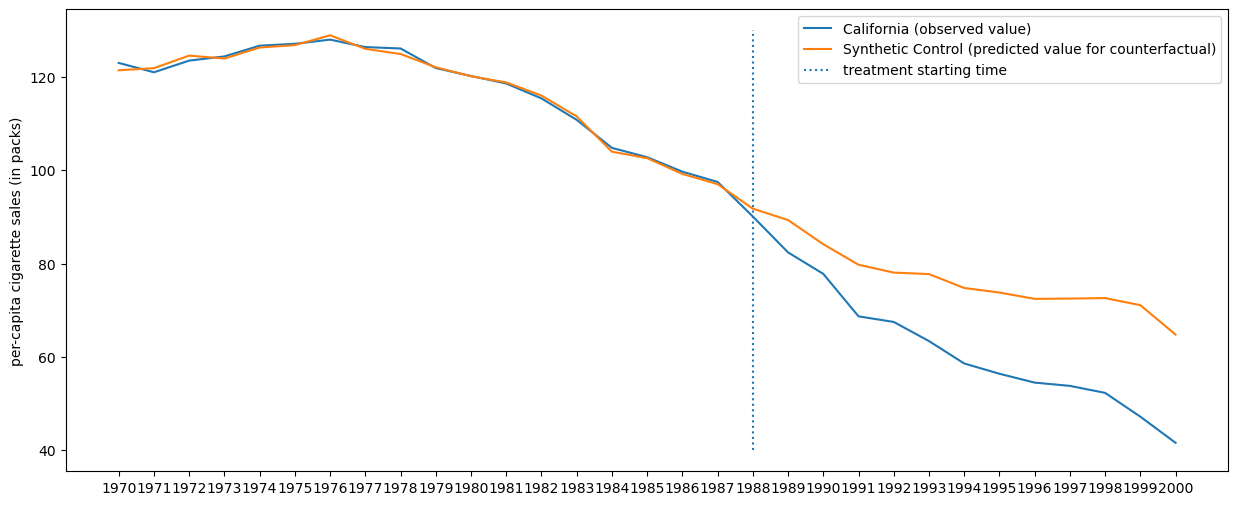

In [88]:
# Step 2: using the weights estimated in Step 1 to estimate the counterfactual of treated unit (California) in post-exposure period
post_expo_R_trt_counterfactual = clf.predict(post_expo_R_ctl)

# now we use a plot to show the estimated post-treatment effect in California.
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(smoke_R.iloc[:,0], label = "California (observed value)")
plt.plot(clf.predict(smoke_R.iloc[:,1:N]), label = "Synthetic Control (predicted value for counterfactual)")
plt.vlines(x="1988", ymin=40, ymax=130, linestyle=":", label="treatment starting time")
plt.ylabel("per-capita cigarette sales (in packs)")
plt.legend();

As we can see from the figure above, the execution of Proposition 99 can effectly reduce the pre-capita cigarette sales in California. The longer time after treatment time, the larger the treatment effect tends to be.

## References

    [1] Abadie, A., Diamond, A., and Hainmueller, J. (2010), “Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program,” Journal of the American Statistical Association, 105, 493–505. [2068,2069,2070,2071]

    [2] Li, K. T. (2020), “Statistical Inference for Average Treatment Effects Esti-mated by Synthetic Control Methods,”Journal of the American StatisticalAssociation, 115, 2068–2083. [1716]